In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_2D(threshold, mu, ndt, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < threshold:
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    
    return ndt+rt, theta

In [3]:
data = pd.read_csv('_data/Kvam_2019_orientation_judgments_data.csv')
data = data[data['isCued'] == 0].reset_index(drop=True)

best_fitting = pd.read_csv('Kvam_2019_best_estimation.csv', index_col=0)

In [4]:
best_fitting.describe()

,sbj,isSpeed,jitter,threshold,mux,muy,ndt,G2
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,150.083333,0.500000,30.000000,1.980626,4.399155,-0.034850,0.250225,-315.543209
std,37.792148,0.503509,12.333397,0.981710,1.848454,0.224724,0.100691,131.533544
min,100.000000,0.000000,15.000000,0.827698,1.607215,-0.604798,0.100000,-598.742881
25%,117.500000,0.000000,15.000000,1.244444,2.920339,-0.191000,0.163096,-401.339075
50%,145.000000,0.500000,30.000000,1.640967,3.946300,-0.009989,0.258058,-308.652027
75%,182.500000,1.000000,45.000000,2.561924,5.782120,0.106548,0.323155,-222.780806
max,210.000000,1.000000,45.000000,4.983516,7.500000,0.495034,0.458960,-51.433746


In [5]:
prediction = {'sbj': [],
              'isSpeed': [],
              'jitter':[],
              'Theta':[],
              'RT':[]}

for sbj in data['Participant'].unique():
    prms_sbj = best_fitting[best_fitting['sbj']==sbj]
    for sp in range(2):
        for jit in [15, 30, 45]:
            prms_cond = prms_sbj[(prms_sbj['isSpeed']==sp) & (prms_sbj['jitter']==jit)]
            threshold = prms_cond['threshold'].values[0]
            ndt = prms_cond['ndt'].values[0]
            mu = np.array([prms_cond['mux'].values[0], 
                           prms_cond['muy'].values[0]])
            

            for n in range(200):
                rt, theta = simulate_HSDM_2D(threshold, mu, ndt)
                prediction['sbj'].append(sbj)
                prediction['isSpeed'].append(sp)
                prediction['jitter'].append(jit)
                prediction['Theta'].append(np.abs(theta))
                prediction['RT'].append(rt)
            

In [6]:
prediction_df = pd.DataFrame(prediction)
prediction_df

,sbj,isSpeed,jitter,Theta,RT
0,100,0,15,0.323682,1.513000
1,100,0,15,0.187427,0.879000
2,100,0,15,0.217681,0.697000
3,100,0,15,0.074409,0.643000
4,100,0,15,0.155241,0.455000
...,...,...,...,...,...
14395,210,1,45,0.095664,0.607418
14396,210,1,45,0.341996,0.817418
14397,210,1,45,0.913206,0.617418
14398,210,1,45,0.858504,0.644418


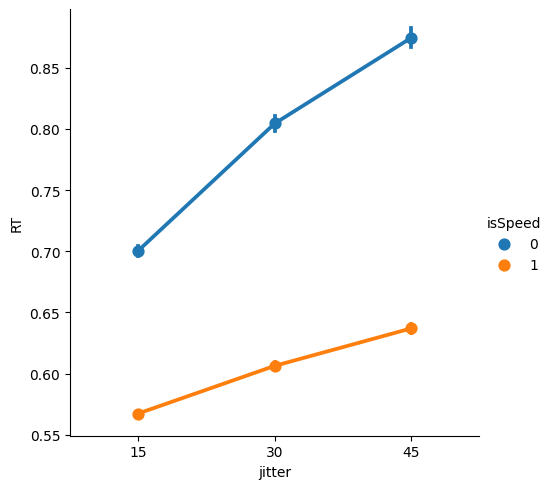

In [7]:
sns.catplot(x='jitter', y='RT', 
            data=prediction_df, hue='isSpeed', 
            kind="point", errorbar="se");

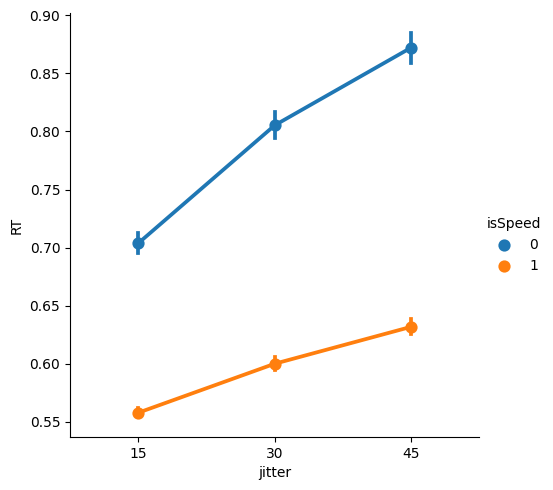

In [8]:
sns.catplot(x='jitter', y='RT', 
            data=data, hue='isSpeed', 
            kind="point", errorbar="se");

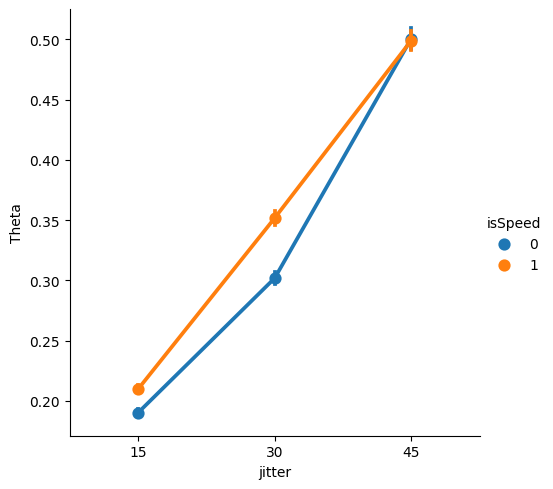

In [9]:
sns.catplot(x='jitter', y='Theta', 
            data=prediction_df, hue='isSpeed', 
            kind="point", errorbar="se");

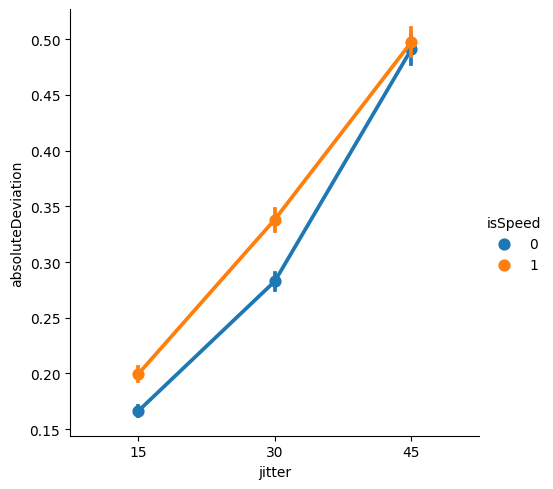

In [10]:
sns.catplot(x='jitter', y='absoluteDeviation', 
            data=data, hue='isSpeed', 
            kind="point", errorbar="se");